# **Sentiment Analysis with Twitter Data**

In this project, I work to classify the sentiment of tweets to be either positive or negative. The dataset used is the Sentiment140 dataset from Kaggle, which is made up of 1.6 million tweets from Twitter that have been denoted either 0 (negative), 2 (neutral), and 4 (positive).


## Importing Libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Understanding the Data

In [2]:
data = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv', encoding="ISO-8859-1")
data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


We include column headers to increase clarity for personal reference and drop the id, date, query, and username fields, as such information is not relevant to a tweet's sentiment. We also label the sentiment column by mapping values of 0 to 'Negative' and values of 4 to 'Positive'.   

In [3]:
data.columns = ['sentiment', 'id', 'date', 'query', 'username','comment']
data = data.drop(['id', 'date', 'query', 'username'], axis=1)
data.head()

,sentiment,comment
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


In [4]:
sentiment = data['sentiment']
sentiment = data['sentiment'].replace(4,1)
data.head()


,sentiment,comment
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Count')

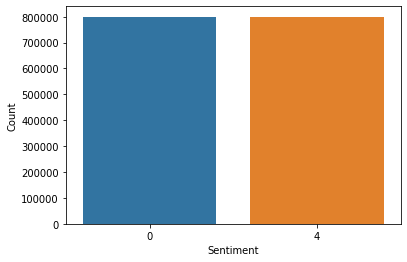

In [5]:
# plt.figure(figsize=(8,4))
# plt.bar(x = data.sentiment.index, height = data.sentiment.values)
# plt.title("Sentiment Data")

plot = sns.countplot(data['sentiment'])
plot.set_xlabel("Sentiment")
plot.set_ylabel("Count")

From the graph, we observe that the sentiment data is evenly distributed.

In [6]:
comments = np.array(data['comment'])
comments[0]

"is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!"

## Data Cleaning + Preprocessing for Model

The next step is to clean the data by:
* removing unnecessary symbols and spaces 
* removing stopwords (words with no contextual meaning)
* stemming words

In [7]:
def clean_comment(comment):
  comment = re.sub(r'#\w*','',comment)
  comment = re.sub(r'@\w*','',comment)
  comment = re.sub(r'https?:\S*','',comment) 
  comment = re.sub(r'\d*','',comment) 
  comment = re.sub(r'\W+',' ',comment) 
  comment = re.sub(r'_','',comment) 
  comment = re.sub(r'\s\S$','',comment) 
  comment = re.sub(r'^\s','',comment) 
  comment = re.sub(r'\s$','',comment) 
  return comment

cleaned_comments = []
comments = np.array(data['comment'])
for comment in comments:
    cleaned_comments.append(clean_comment(comment))
print(cleaned_comments[0])

is upset that he can t update his Facebook by texting it and might cry as a result School today also Blah


In [8]:
split_comments = []
for comment in cleaned_comments:
    split_comments.append(comment.split())
print(split_comments[0])

['is', 'upset', 'that', 'he', 'can', 't', 'update', 'his', 'Facebook', 'by', 'texting', 'it', 'and', 'might', 'cry', 'as', 'a', 'result', 'School', 'today', 'also', 'Blah']


In [9]:
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [10]:
def remove_stopwords(words):
    final_words = []
    for word in words:
        if word.lower() not in stop_words:
            final_words.append(word)
    return final_words
    

In [11]:
clean_comments=[]
for comment in split_comments:
    clean_comments.append(remove_stopwords(comment))
print(clean_comments[0])

['upset', 'update', 'Facebook', 'texting', 'might', 'cry', 'result', 'School', 'today', 'also', 'Blah']


In [12]:
for comment in range(len(clean_comments)):
  for i in range(len(clean_comments[comment])):
    clean_comments[comment][i] = clean_comments[comment][i].lower()
print(clean_comments[0])

['upset', 'update', 'facebook', 'texting', 'might', 'cry', 'result', 'school', 'today', 'also', 'blah']


In [13]:
stemmer = SnowballStemmer('english')
for i in range(len(clean_comments)):
    for j in range(len(clean_comments[i])):
        clean_comments[i][j] = stemmer.stem(clean_comments[i][j])

In [14]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_comments)
seq_comments = tokenizer.texts_to_sequences(clean_comments)
seq_comments[0]

[591, 219, 431, 352, 203, 233, 967, 75, 9, 186, 983]

In [15]:
pad_seq_comments=pad_sequences(seq_comments)
pad_seq_comments[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0, 591, 219, 431, 352, 203, 233, 967,  75,   9, 186,
       983], dtype=int32)

In [16]:
sentiment = data['sentiment']
sentiment = data['sentiment'].replace(4,1)
data['sentiment']

0          0
1          0
2          0
3          0
4          0
          ..
1599994    4
1599995    4
1599996    4
1599997    4
1599998    4
Name: sentiment, Length: 1599999, dtype: int64

In [17]:
sentiment.unique()

array([0, 1])

In [18]:
word_amt = len(tokenizer.word_index)
word_amt

221038

## Model Building
We can now build the model with a LSTM neural network.

In [19]:
x_train,x_test,y_train,y_test = train_test_split(pad_seq_comments,sentiment,test_size=0.1)

In [20]:
x_train

array([[    0,     0,     0, ...,    12, 12100,   717],
       [    0,     0,     0, ...,     0,   194, 18677],
       [    0,     0,     0, ...,    84,   905,   316],
       ...,
       [    0,     0,     0, ...,   103,   506,    60],
       [    0,     0,     0, ...,    65,   210,   254],
       [    0,     0,     0, ...,   338,   173,   260]], dtype=int32)

In [21]:
y_train

907937     1
998113     1
1382300    1
1004606    1
289686     0
          ..
1586178    1
6223       0
1167885    1
1226297    1
335725     0
Name: sentiment, Length: 1439999, dtype: int64

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout,Embedding,Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau


model = Sequential()
model.add(Embedding(word_amt+1,15,input_length=50))
model.add(Bidirectional(LSTM(units=64)))
model.add(Dense(1,activation='sigmoid'))

model.compile(optimizer='Adam',
              loss="binary_crossentropy",
              metrics=['accuracy'])
model.summary()

2022-07-27 22:24:40.017668: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 15)            3315585   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               40960     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 3,356,674
Trainable params: 3,356,674
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = model.fit(x_train,y_train,
                    validation_data = (x_test, y_test),
                    validation_split=0.1,
                    batch_size=1024,
                    verbose = 1,
                    epochs=5)

2022-07-27 22:24:41.350607: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
1266/1266 [==============================] - 1031s 811ms/step - loss: 0.4895 - accuracy: 0.7617 - val_loss: 0.4669 - val_accuracy: 0.7771
Epoch 2/5
1266/1266 [==============================] - 1064s 840ms/step - loss: 0.4456 - accuracy: 0.7902 - val_loss: 0.4607 - val_accuracy: 0.7808
Epoch 3/5
1266/1266 [==============================] - 1082s 854ms/step - loss: 0.4278 - accuracy: 0.7997 - val_loss: 0.4644 - val_accuracy: 0.7795
Epoch 4/5
1266/1266 [==============================] - 1074s 848ms/step - loss: 0.4093 - accuracy: 0.8091 - val_loss: 0.4722 - val_accuracy: 0.7767
Epoch 5/5
1266/1266 [==============================] - 1071s 846ms/step - loss: 0.3943 - accuracy: 0.8171 - val_loss: 0.4820 - val_accuracy: 0.7768


In [24]:
predictions = model.predict(x_test)
predictions

array([[0.51068753],
       [0.06143385],
       [0.8882861 ],
       ...,
       [0.5128004 ],
       [0.12712082],
       [0.934564  ]], dtype=float32)

In [25]:
from sklearn.metrics import accuracy_score

result = []
for pred in predictions:
  if pred >= 0.5:
    result.append(1)
  else:
    result.append(0)

accuracy_score(y_test,result)

0.7769875

We observe that the model results in a test accuracy of 77.61%.

## Model Performance

Below are visualizations of the model's performance.

Test Accuracy Results
              precision    recall  f1-score   support

           0       0.77      0.79      0.78     79977
           1       0.78      0.77      0.77     80023

    accuracy                           0.78    160000
   macro avg       0.78      0.78      0.78    160000
weighted avg       0.78      0.78      0.78    160000



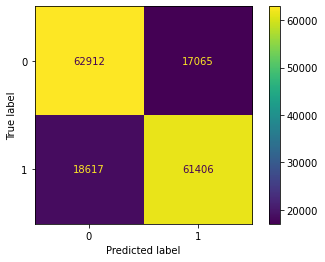

In [26]:
print("Test Accuracy Results")
prediction_test = model.predict(x_test)
prediction_test[prediction_test >= 0.5] = 1
prediction_test[prediction_test < 0.5] = 0
print(classification_report(y_test,prediction_test))
ConfusionMatrixDisplay.from_predictions(y_test,prediction_test)
plt.show()

Text(0.5, 0, 'Number of Epochs')

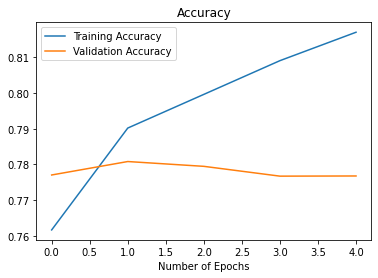

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.title('Accuracy')
plt.xlabel('Number of Epochs')

Text(0.5, 0, 'Number of Epochs')

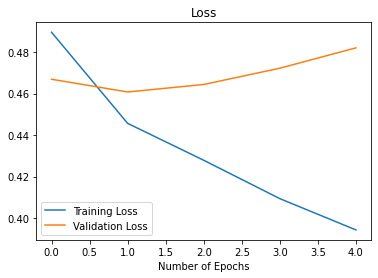

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training Loss','Validation Loss'])
plt.title('Loss')
plt.xlabel('Number of Epochs')